In [278]:
!pip install yfinance

[*********************100%***********************]  2 of 2 completed


Ticker           ADBE       MSFT
Date                            
2013-10-01  52.099998  33.349998
2013-10-02  51.790001  33.360001
2013-10-03  51.610001  33.880001
2013-10-04  50.090000  33.689999
2013-10-07  51.049999  33.599998


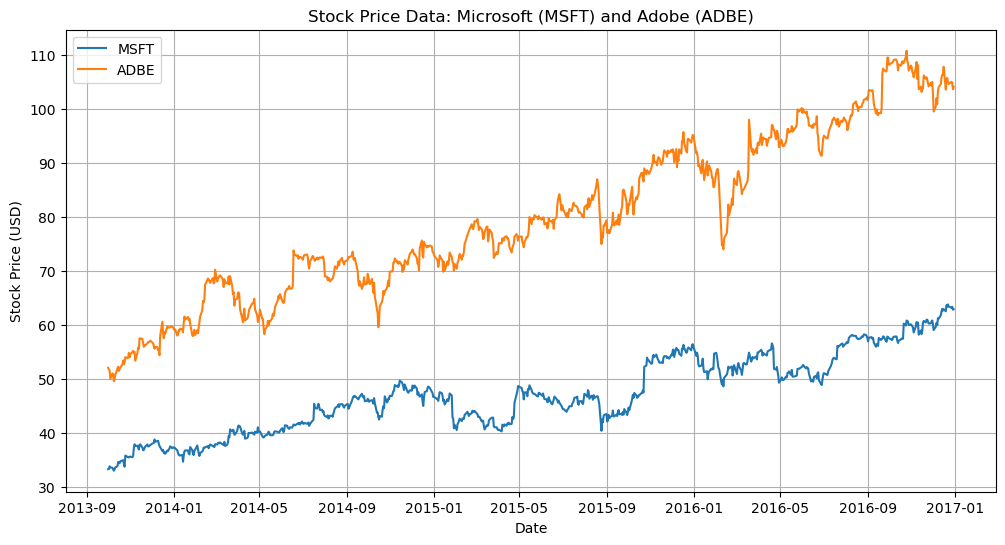

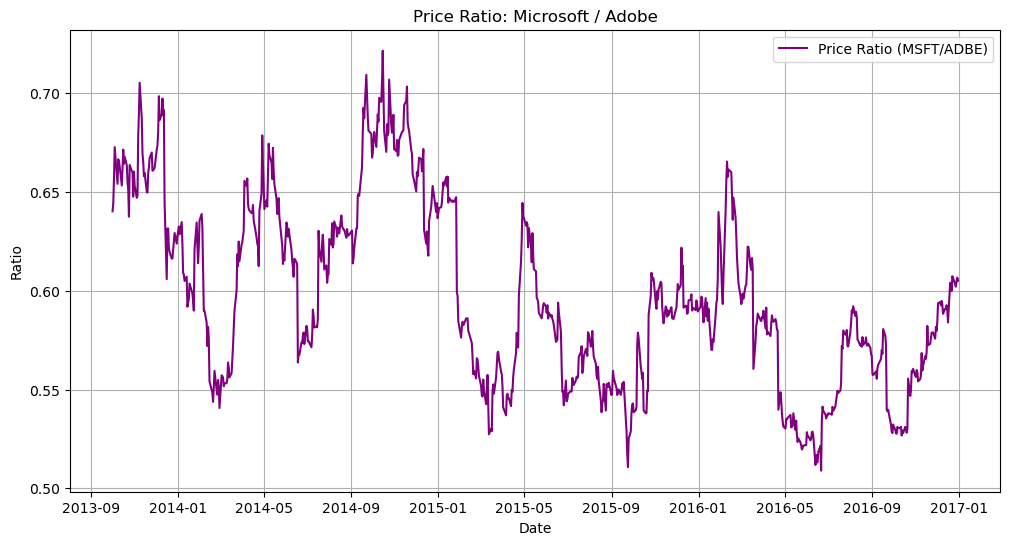

In [279]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
tickers = ['MSFT', 'ADBE']

data = yf.download(tickers, start="2013-10-01", end="2016-12-31")['Open']
print(data.head())
data['Ratio'] = data['MSFT'] / data['ADBE']
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)

plt.title("Stock Price Data: Microsoft (MSFT) and Adobe (ADBE)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['Ratio'], label='Price Ratio (MSFT/ADBE)', color='purple')
plt.title("Price Ratio: Microsoft / Adobe")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.legend()
plt.grid(True)
plt.show()


data.to_csv("stock_prices_msft_adbe.csv")


In [280]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Ratio'].dropna())  

adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Number of Lags Used": adf_test[2],
    "Number of Observations": adf_test[3]
}
print("ADF Test Results:")
for key, value in adf_result.items():
    print(f"{key}: {value}")


ADF Test Results:
ADF Statistic: -2.988637078579067
p-value: 0.035969266530887396
Number of Lags Used: 0
Number of Observations: 819


In [281]:
#Augmented Dickey Fuller test produces a decent <0.05 p-value, so we can assume stationarity of price ratio time series
!pip install pandas_datareader

In [282]:
import pandas_datareader as pdr
from datetime import datetime
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2020, 10, 27), end=datetime(2021, 10, 27)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["DPZ", "AAPL", "GOOG","ADBE", "MSFT"] #Name of company (Dominos pizza)
d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

(252, 5)


,DPZ,AAPL,GOOG,ADBE,MSFT
Date,,,,,
2021-10-20,465.170013,148.699997,144.222504,639.280029,309.209991
2021-10-21,460.649994,148.809998,142.192001,632.000000,307.170013
2021-10-22,467.809998,149.690002,140.350998,640.429993,310.399994
2021-10-25,464.250000,148.679993,138.810501,644.469971,309.359985
2021-10-26,467.519989,149.330002,140.606003,650.909973,311.000000


Ticker            ADBE       MSFT     Ratio     MAVG5    MAVG20    MAVG60  \
Date                                                                        
2016-12-23  104.610001  63.450001  0.606539  0.604289  0.592397  0.564561   
2016-12-27  105.000000  63.209999  0.602000  0.603882  0.593711  0.565722   
2016-12-28  104.830002  63.400002  0.604789  0.604100  0.594868  0.566976   
2016-12-29  103.629997  62.860001  0.606581  0.605443  0.596213  0.568290   
2016-12-30  104.070000  62.959999  0.604977  0.604977  0.597231  0.569579   

Ticker         STD20     STD60  ZScore20_5  ZScore60_5  RateOfChange  
Date                                                                  
2016-12-23  0.008792  0.025208    1.352652    1.576012     -0.126352  
2016-12-27  0.008104  0.025302    1.255021    1.508144     -0.748276  
2016-12-28  0.007942  0.025344    1.162435    1.464815      0.463242  
2016-12-29  0.007500  0.025319    1.230674    1.467393      0.296371  
2016-12-30  0.007219  0.025184    

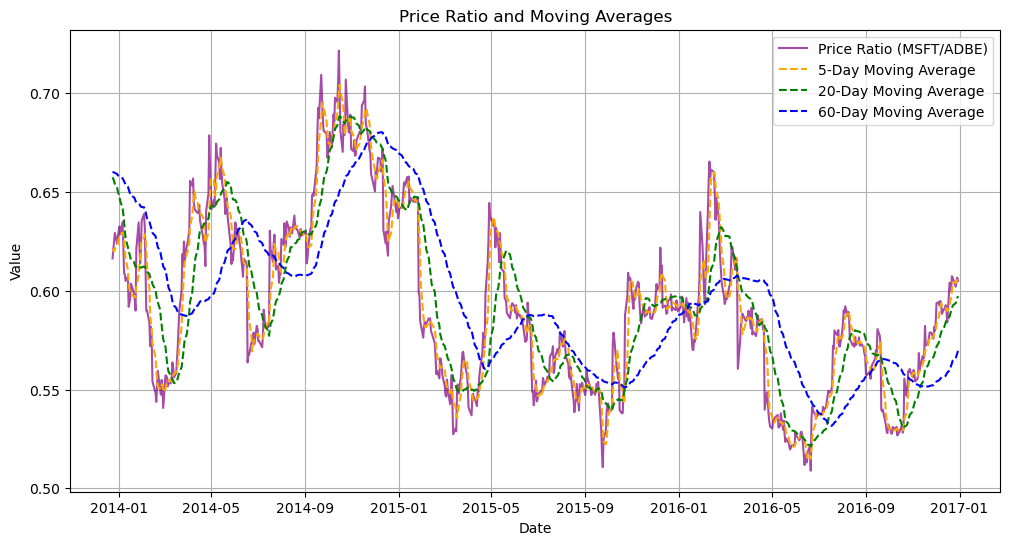

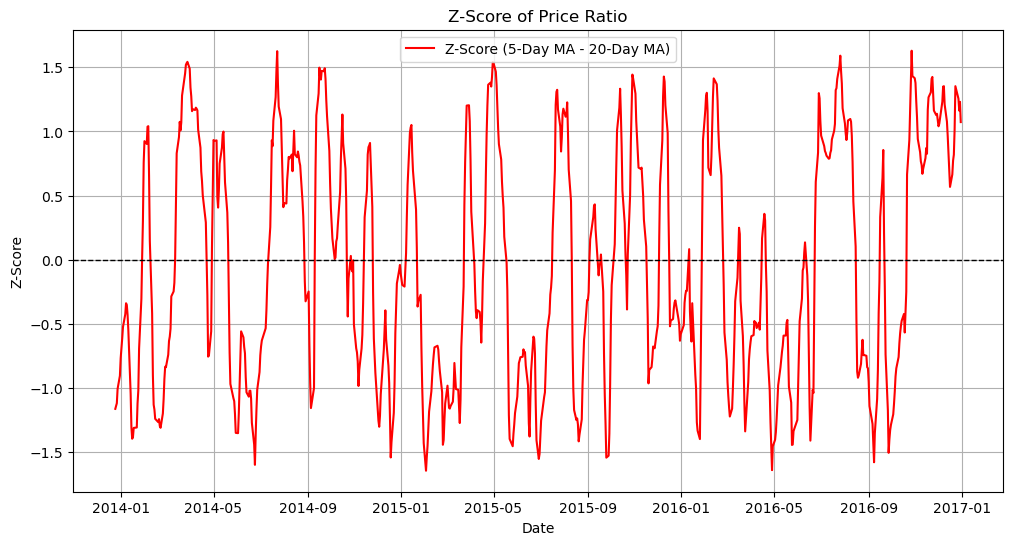

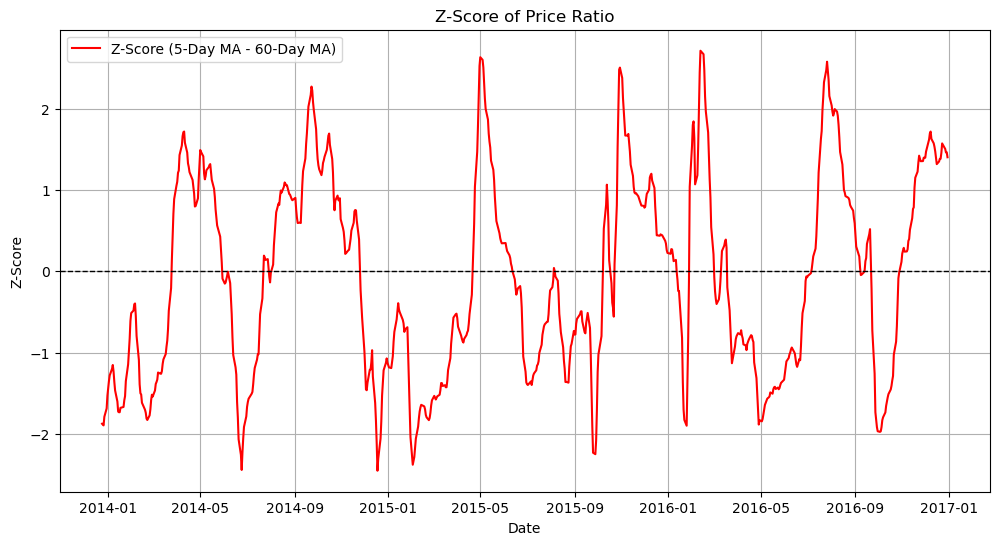

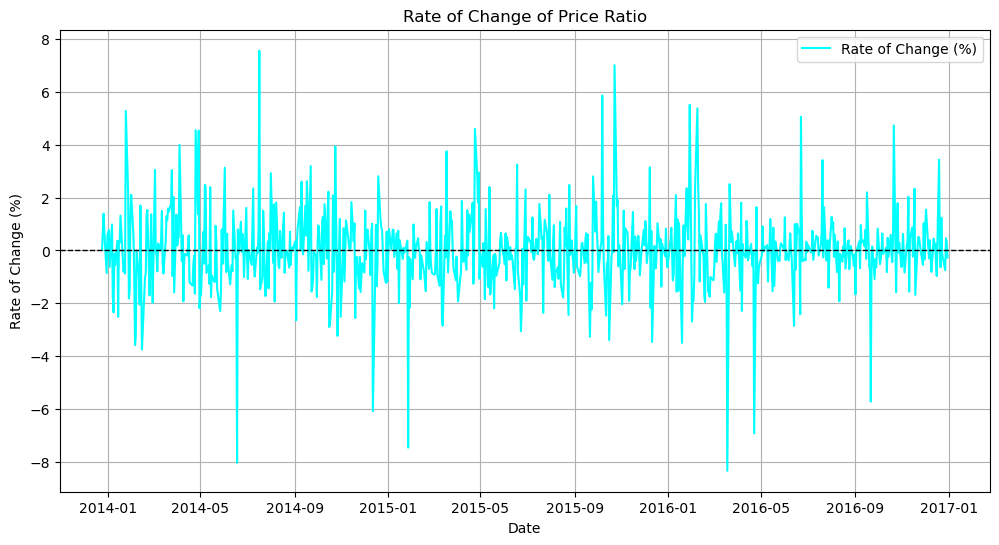

ADF Test Results:
ADF Statistic: -27.34898259869071
p-value: 0.0
Number of Lags Used: 0
Number of Observations: 760


In [283]:
# Calculate moving averages (5-day, 20-day, and 60-day)
data['MAVG5'] = data['Ratio'].rolling(window=5).mean()
data['MAVG20'] = data['Ratio'].rolling(window=20).mean()
data['MAVG60'] = data['Ratio'].rolling(window=60).mean()

# Calculate the 20-day rolling standard deviation of the ratio
data['STD20'] = data['Ratio'].rolling(window=20).std()
data['STD60'] = data['Ratio'].rolling(window=60).std()

# Calculate the z-score (20-day MA and 5-day MA)
data['ZScore20_5'] = (data['MAVG5'] - data['MAVG20']) / data['STD20']
data['ZScore60_5'] = (data['MAVG5'] - data['MAVG60']) / data['STD60']

# Calculate the rate of change (percentage change over 1 day)
data['RateOfChange'] = data['Ratio'].pct_change() * 100

# Drop rows with NaN values (caused by insufficient data for rolling calculations)
data = data.dropna()

# Display the last few rows of the DataFrame
print(data.tail())

# Plot the ratio and moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Ratio'], label='Price Ratio (MSFT/ADBE)', color='purple', alpha=0.7)
plt.plot(data['MAVG5'], label='5-Day Moving Average', color='orange', linestyle='--')
plt.plot(data['MAVG20'], label='20-Day Moving Average', color='green', linestyle='--')
plt.plot(data['MAVG60'], label='60-Day Moving Average', color='blue', linestyle='--')
plt.title("Price Ratio and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot the z-score
plt.figure(figsize=(12, 6))
plt.plot(data['ZScore20_5'], label='Z-Score (5-Day MA - 20-Day MA)', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at z-score = 0
plt.title("Z-Score of Price Ratio")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['ZScore60_5'], label='Z-Score (5-Day MA - 60-Day MA)', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at z-score = 0
plt.title("Z-Score of Price Ratio")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

# Plot the rate of change
plt.figure(figsize=(12, 6))
plt.plot(data['RateOfChange'], label='Rate of Change (%)', color='cyan')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at ROC = 0
plt.title("Rate of Change of Price Ratio")
plt.xlabel("Date")
plt.ylabel("Rate of Change (%)")
plt.legend()
plt.grid(True)
plt.show()

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['RateOfChange'].dropna())  

adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Number of Lags Used": adf_test[2],
    "Number of Observations": adf_test[3]
}
print("ADF Test Results:")
for key, value in adf_result.items():
    print(f"{key}: {value}")


RBF Kernel SVM Results:
Mean Squared Error: 0.0001
R-squared: 0.7757
Trend Detection Accuracy: 48.86%

Linear Kernel SVM Results:
Mean Squared Error: 0.0001
R-squared: 0.8837
Trend Detection Accuracy: 47.16%


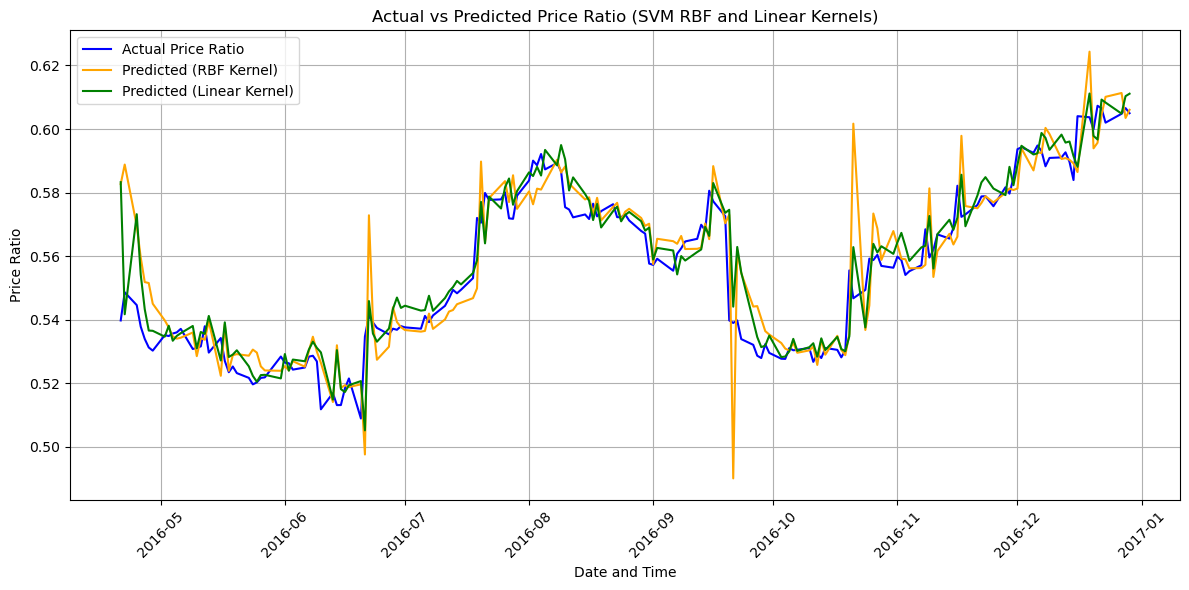

In [284]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering (same as before)
data['MAVG5'] = data['Ratio'].rolling(window=5).mean()
data['MAVG20'] = data['Ratio'].rolling(window=20).mean()
data['MAVG60'] = data['Ratio'].rolling(window=60).mean()
data['STD20'] = data['Ratio'].rolling(window=20).std()
data['ZScore20_5'] = (data['MAVG5'] - data['MAVG20']) / data['STD20']
data['RateOfChange'] = data['Ratio'].pct_change() * 100
data['FutureRatio'] = data['Ratio'].shift(-1)  # Predict the next price ratio

# Drop rows with NaN values
data = data.dropna()

# Define features and target
features = ['MAVG5', 'MAVG20', 'MAVG60', 'STD20', 'ZScore20_5', 'RateOfChange']
X = data[features]
y = data['FutureRatio']

# Split the data into training and testing sets (first 80% for training, last 20% for testing)
train_size = int(len(data) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train and predict using the RBF kernel SVM
svm_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

# Train and predict using the Linear kernel SVM
svm_linear = SVR(kernel='linear', C=100, epsilon=0.01)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

# Evaluate both models
mse_rbf = mean_squared_error(y_test, y_pred_rbf)
r2_rbf = r2_score(y_test, y_pred_rbf)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Calculate trend accuracy for both models
actual_trend = np.sign(y_test.diff().fillna(0))  # +1 for increase, -1 for decrease, 0 for no change
predicted_trend_rbf = np.sign(np.diff([y_test.iloc[0]] + list(y_pred_rbf)))  # Align lengths
predicted_trend_linear = np.sign(np.diff([y_test.iloc[0]] + list(y_pred_linear)))  # Align lengths

trend_accuracy_rbf = np.mean(actual_trend == predicted_trend_rbf) * 100
trend_accuracy_linear = np.mean(actual_trend == predicted_trend_linear) * 100

# Print evaluation metrics for both models
print("RBF Kernel SVM Results:")
print(f"Mean Squared Error: {mse_rbf:.4f}")
print(f"R-squared: {r2_rbf:.4f}")
print(f"Trend Detection Accuracy: {trend_accuracy_rbf:.2f}%")

print("\nLinear Kernel SVM Results:")
print(f"Mean Squared Error: {mse_linear:.4f}")
print(f"R-squared: {r2_linear:.4f}")
print(f"Trend Detection Accuracy: {trend_accuracy_linear:.2f}%")

# Plot predicted vs actual price ratios for both SVM models
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], y_test, label='Actual Price Ratio', color='blue')
plt.plot(data.index[train_size:], y_pred_rbf, label='Predicted (RBF Kernel)', color='orange')
plt.plot(data.index[train_size:], y_pred_linear, label='Predicted (Linear Kernel)', color='green')
plt.xlabel('Date and Time')
plt.ylabel('Price Ratio')
plt.title('Actual vs Predicted Price Ratio (SVM RBF and Linear Kernels)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\shubh\AppData\Local\Temp\ipykernel_12292\3931905324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['PredictedFutureRatio_RBF'] = y_pred_rbf
C:\Users\shubh\AppData\Local\Temp\ipykernel_12292\3931905324.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['PredictedFutureRatio_Linear'] = y_pred_linear
C:\Users\shubh\AppData\Local\Temp\ipykernel_12292\3931905324.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Ticker      PredictedFutureRatio_RBF  ZScore_pred
Date                                             
2016-05-18                  0.523955    -0.697826
2016-05-19                  0.528830    -0.682730
2016-05-20                  0.529176    -0.852041
2016-05-23                  0.528687    -0.712071
2016-05-24                  0.530606    -0.876572


ConversionError: Failed to convert value(s) to axis units: '2013-08-15'

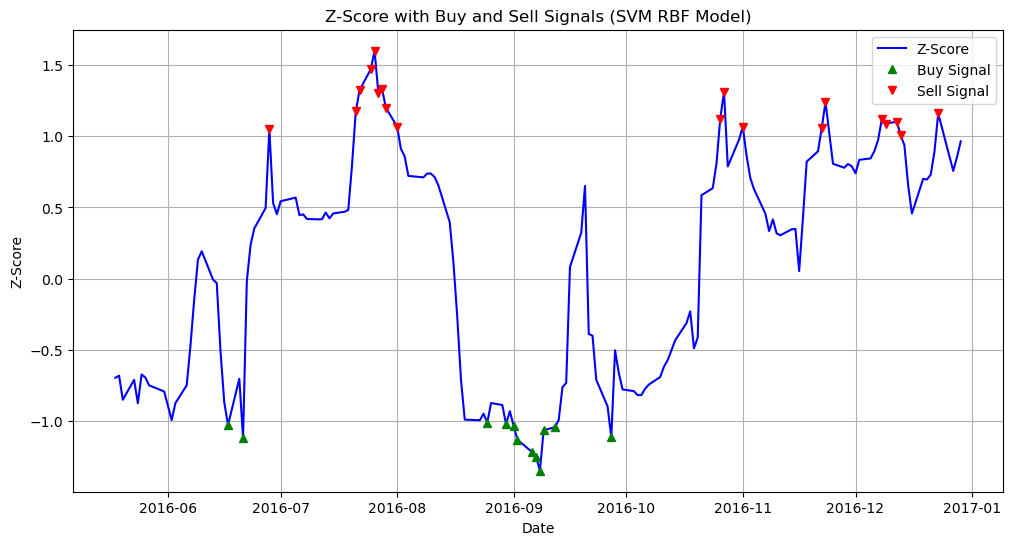

In [285]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Feature Engineering for the Test Data (Predicted Future Ratio)
# Assuming 'y_pred_rbf' and 'y_pred_linear' are the predicted values from the SVM models
data_test = data.iloc[train_size:]  # Take the test data from the original dataset

# Use the predicted values from both SVM models (RBF and Linear)
data_test['PredictedFutureRatio_RBF'] = y_pred_rbf
data_test['PredictedFutureRatio_Linear'] = y_pred_linear

# Choose the predicted ratio to use (You can use either one or both for comparison)
ratios_pred = data_test['PredictedFutureRatio_RBF']  # Use the predicted future ratio from RBF model

# Calculate moving averages and standard deviation for the predicted ratios
data_test['MAVG5_pred'] = ratios_pred.rolling(window=5).mean()
data_test['MAVG20_pred'] = ratios_pred.rolling(window=20).mean()
data_test['STD20_pred'] = ratios_pred.rolling(window=20).std()

# Calculate the Z-score for the predicted ratios
data_test['ZScore_pred'] = (data_test['MAVG5_pred'] - data_test['MAVG20_pred']) / data_test['STD20_pred']

# Drop rows with NaN values after calculating the rolling statistics
data_test = data_test.dropna()

# Display the new Z-scores for the test data
print(data_test[['PredictedFutureRatio_RBF', 'ZScore_pred']].head())

# Generate buy and sell signals based on the Z-score thresholds
buy_signal = (data_test['ZScore_pred'] < -1).astype(int)  # Buy signal when Z-score is below -1
sell_signal = (data_test['ZScore_pred'] > 1).astype(int)  # Sell signal when Z-score is above 1

# Plot the Z-scores
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['ZScore_pred'], label='Z-Score', color='blue')

# Plot Buy and Sell signals
plt.plot(data_test.index[buy_signal == 1], data_test['ZScore_pred'][buy_signal == 1], 
         marker='^', color='green', linestyle='None', label='Buy Signal')
plt.plot(data_test.index[sell_signal == 1], data_test['ZScore_pred'][sell_signal == 1], 
         marker='v', color='red', linestyle='None', label='Sell Signal')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score with Buy and Sell Signals (SVM RBF Model)')
plt.legend(loc='best')
plt.grid(True)

# Limit the x-axis to a specific range (example: from '2013-08-15' to '2016-07-07')
plt.xlim('2013-08-15', '2016-07-07')

# Show the plot
plt.tight_layout()
plt.show()


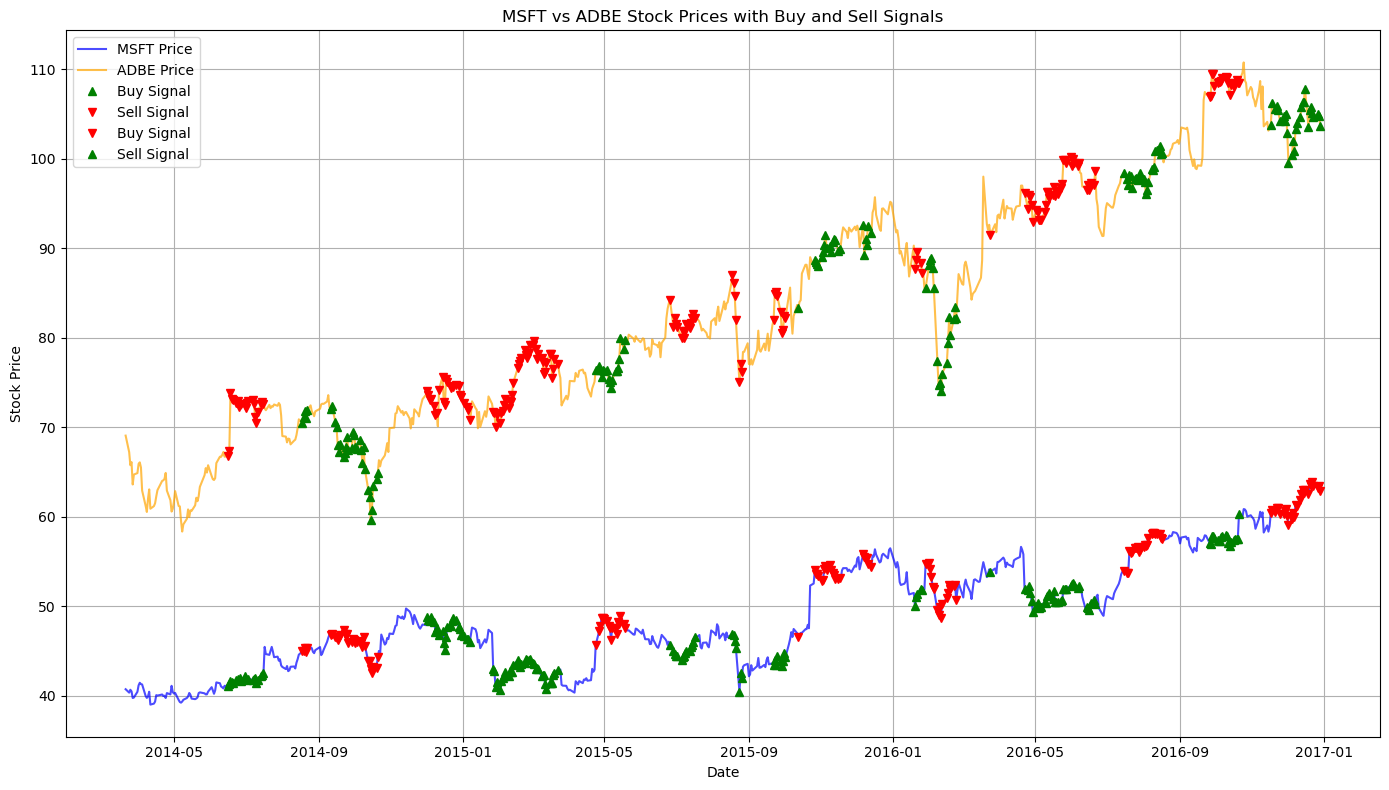

In [289]:
import matplotlib.pyplot as plt

# Assuming `data` is a DataFrame with 'MSFT' and 'ADBE' columns representing the stock prices
# Compute the price ratios between MSFT and ADBE (you can adjust this if you need another measure)
data['Ratio'] = data['MSFT'] / data['ADBE']

# Calculate moving averages and standard deviations for the Z-score
data['MAVG60'] = data['Ratio'].rolling(window=60).mean()  # 60-day moving average
data['MAVG5'] = data['Ratio'].rolling(window=5).mean()  # 5-day moving average
data['STD60'] = data['Ratio'].rolling(window=60).std()  # 60-day standard deviation

# Calculate the Z-score
data['ZScore'] = (data['MAVG5'] - data['MAVG60']) / data['STD60']

# Generate Buy and Sell signals based on the Z-score
buy_signal = (data['ZScore'] < -1).astype(int)  # Buy signal when Z-score < -1
sell_signal = (data['ZScore'] > 1).astype(int)  # Sell signal when Z-score > 1

# Plot stock prices (MSFT and ADBE)
plt.figure(figsize=(14, 8))

# Plot MSFT and ADBE stock prices
plt.plot(data.index, data['MSFT'], label='MSFT Price', color='blue', alpha=0.7)
plt.plot(data.index, data['ADBE'], label='ADBE Price', color='orange', alpha=0.7)

# Plot Buy and Sell signals on the stock price graph
plt.plot(data.index[buy_signal == 1], data['MSFT'][buy_signal == 1], 
         marker='^', color='green', linestyle='None', label='Buy Signal')
plt.plot(data.index[sell_signal == 1], data['MSFT'][sell_signal == 1], 
         marker='v', color='red', linestyle='None', label='Sell Signal')
plt.plot(data.index[buy_signal == 1], data['ADBE'][buy_signal == 1], 
         marker='v', color='red', linestyle='None', label='Buy Signal')
plt.plot(data.index[sell_signal == 1], data['ADBE'][sell_signal == 1], 
         marker='^', color='green', linestyle='None', label='Sell Signal')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('MSFT vs ADBE Stock Prices with Buy and Sell Signals')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\shubh\AppData\Local\Temp\ipykernel_12292\3364856992.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -1:
C:\Users\shubh\AppData\Local\Temp\ipykernel_12292\3364856992.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > 1:
C:\Users\shubh\AppData\Local\Temp\ipykernel_12292\3364856992.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.75:
C:\Users\shubh\AppData\Loca

Final Money after trading: -393.33


NameError: name 'zscore' is not defined

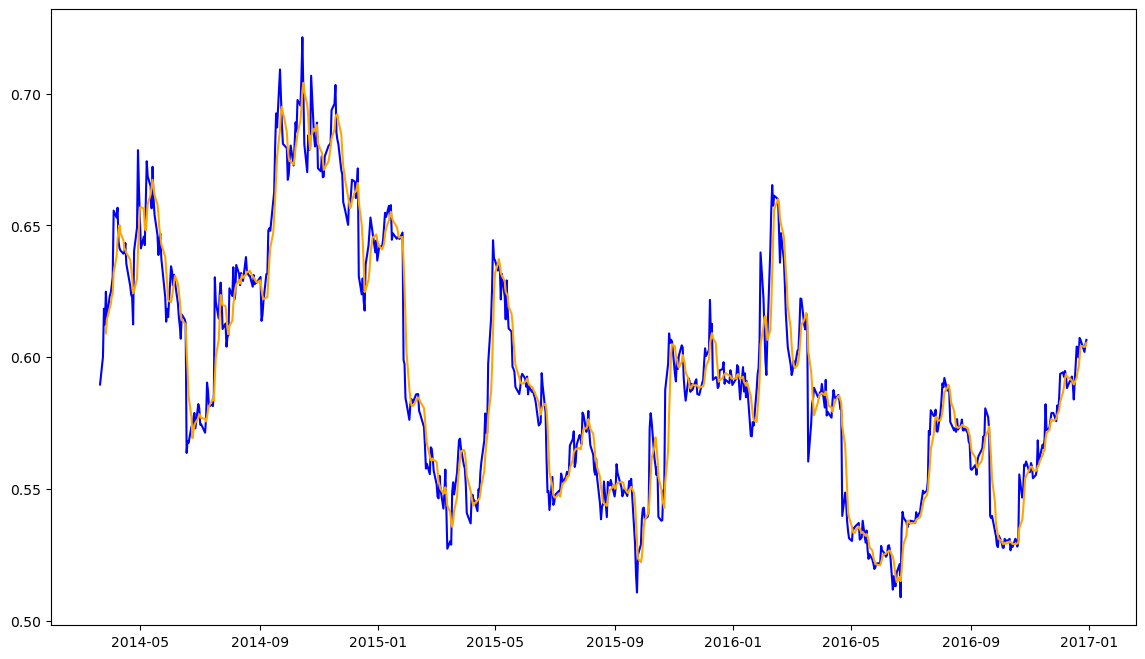

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming S1 and S2 are pandas Series containing the stock prices of two assets.
# Let's define the trade function using the logic you've provided.

def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std

    # Initialize money and positions (tracking of shares held)
    money = 0
    countS1 = 0  # Position in S1 (short or long)
    countS2 = 0  # Position in S2 (short or long)
    for i in range(len(ratios)):
        # Sell short if Z-score < -1
        if zscore[i] < -1:
            # Calculate the amount of money earned from shorting
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1  # Increasing short position on S1
            countS2 += ratios[i]  # Increasing long position on S2
        # Buy long if Z-score > 1
        elif zscore[i] > 1:
            # Calculate the amount of money spent on buying
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1  # Increasing long position on S1
            countS2 -= ratios[i]  # Reducing short position on S2
        # Exit positions if Z-score is between -0.75 and 0.75
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0  # Exit position in S1
            countS2 = 0  # Exit position in S2

    # Return the final amount of money at the end of the trading
    return money

# Example usage with stock data (assuming `data` contains stock prices of two assets 'MSFT' and 'ADBE')
window1 = 5  # Example moving average window 1
window2 = 60  # Example moving average window 2

# Assuming data['MSFT'] and data['ADBE'] contain the respective stock prices
final_money = trade(data['MSFT'], data['ADBE'], window1, window2)
print(f"Final Money after trading: {final_money:.2f}")

# Plot the Z-score and Buy/Sell signals
plt.figure(figsize=(14, 8))
plt.plot(data.index, (data['MSFT'] / data['ADBE']), label="Price Ratio (MSFT/ADBE)", color='blue')
plt.plot(data.index, (data['MSFT'] / data['ADBE']).rolling(window=window1).mean(), label=f"Rolling Mean (Window {window1})", color='orange')

# Plot Buy and Sell signals based on Z-score
buy_signal = (zscore < -1)  # Buy signal when Z-score is below -1
sell_signal = (zscore > 1)  # Sell signal when Z-score is above 1

plt.plot(data.index[buy_signal], (data['MSFT'][buy_signal] / data['ADBE'][buy_signal]), 'g^', markersize=10, label="Buy Signal")
plt.plot(data.index[sell_signal], (data['MSFT'][sell_signal] / data['ADBE'][sell_signal]), 'rv', markersize=10, label="Sell Signal")

# Customize plot
plt.xlabel("Date")
plt.ylabel("Price Ratio (MSFT/ADBE)")
plt.title("Trading Strategy based on Z-Score: Buy/Sell Signals")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
